In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
import seaborn as sns
import sqlalchemy
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

from database_credentials import get_database_url

In [2]:
stop_words = set(stopwords.words("english"))
plt.style.use("ggplot")

In [3]:
def check_for_missing_data(data):
    """Print whether or not data contains missing data 
    along with the number of missing entries
    
    Args:
        data (dataframe): dataframe to be checked
        
    Returns:
        None
    """
    
    valid_mask = data.isnull()
    data_contains_missing_values = valid_mask.any().any()
    print("Contains missing values:", data_contains_missing_values)

    if (data_contains_missing_values):
        number_of_missing_values = valid_mask.sum().sum()
        print("Number of missing values:", number_of_missing_values)
    
def check_for_duplicate_ids(data):
    """Print whether or not data contains duplicate 
    Steam IDs along with the number of duplicates
    
    Args:
        data (dataframe): dataframe to be checked
        
    Returns:
        None
    """
    
    unique_id_mask = data['steam_id'].duplicated()
    data_contains_duplicates = unique_id_mask.any()
    print("\nContains duplicate Steam IDs:", data_contains_duplicates)

    if (data_contains_duplicates):
        number_of_duplicates = len(data[unique_id_mask])
        print("Number of duplicate Steam IDs:", number_of_duplicates)
        
def display_info(data):
    """Display the column names, number of rows, and information 
    regarding missing or duplicate values for a dataframe
    
    Args:
        data (dataframe): dataframe for which information will
                          be displayed
    Returns:
        None
    """
    
    print("Column Name and Types:\n{0}\n".format(data.dtypes))
    print("Number of rows: {0}\n".format(data.shape[0]))
    check_for_missing_data(data)
        
def mask_duplicate_ids(data):
    """Mask rows containing duplicate Steam IDs
    
    Args:
        data (dataframe): dataframe with duplicate Steam IDs

    Returns:
        masked_data (dataframe): a copy of data without duplicate
                                 Steam IDs
    """
    
    duplicate_id_mask = ~data['steam_id'].duplicated()
    masked_data = data[duplicate_id_mask]
    return masked_data

def get_review_rating(review):
    """Get the rating from review if applicable
    
    Args: 
        review (str): Steam review
        
    Returns:
        rating_numerator (float/None): "n/10" rating within the review
    """
    
    rating_numerator = None
    match = re.search(r'(\d+(\.\d+)?)/10', review)
    if (match):
        rating = match[0]
        split_rating = rating.split('/')
        rating_numerator = float(split_rating[0])
        
    return rating_numerator

def graph_word_cloud(corpus):
    """Graph a word cloud based on corpus
    
    Args:
        corpus (str): contains the text data
    
    Returns:
        None
    """
    
    word_cloud = WordCloud(
        width=1600, height=800, 
        collocations=False
    ).generate(corpus)
    
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
def get_percentage_change(initial_value, final_value):
    """Get the percentage change between two numbers
    
    Args: 
        initial_value (int/float): number before change
        final_value (int/float): number after change
        
    Returns:
        percentage_change (float): 
    """
    
    change = (initial_value - final_value) / initial_value
    percentage_change = round(change * 100, 2)
    return percentage_change

def filter_tokens(tokens):
    """remove stopwords and punctuation from a list of tokens
    
    Args: 
        tokens (list): 
            words and punctuation as separate list elements         
        
    Returns:
        filtered_tokens (list): filtered tokens
    """
    
    filtered_tokens = [
        t for t in tokens if t not in (stop_words and string.punctuation)
    ]
    return filtered_tokens
    
def preprocess_review(review):
    """Preprocess review by converting to lowercase, tokenizing
    and filtering
    
    Args: 
        review (str): user review         
        
    Returns:
        preprocessed_review (list): filtered tokens
    """
    
    lower_review = review.lower()
    preprocessed_review = word_tokenize(review.lower(), language='english')
    preprocessed_review = filter_tokens(preprocessed_review)
    return preprocessed_review

def initialize_term_df(vocab_list, label):
    """Initialize a dataframe containing terms within the
    same category
    
    Args: 
        vocab_list (list): list of terms within a category
        label (str): string indicating category
        
    Returns:
        term_df (dataframe): 
            dataframe containing terms and their labels
    """
    
    term_df = pd.DataFrame(vocab_list, columns=['term'])
    term_df['label'] = label
    return term_df

def get_date_last_played_counts(data, column_name):
    """Get the number of players who last played in a given year or
    year and month between 2013-03 and 2020-03
    
    Args: 
        data (dataframe): dataframe containing column_name
        column_name (str): 
            specifies the format (year or year-month) along with
            the column containing the dates to be counted
        
    Returns:
        date_last_played (dataframe): 
            dataframe with the dates as indices and first column
            containing the date counts
    """
    
    date_boundaries = {
        'year_last_played': ("2013", "2020"),
        'year_month_last_played': ("2013-03", "2020-03")
    }
    boundaries = date_boundaries[column_name]
    
    date_last_played = data[column_name]
    date_last_played = date_last_played.value_counts()
    date_last_played = date_last_played.sort_index()
    
    date_last_played = date_last_played[
        (date_last_played.index >= boundaries[0]) &
        (date_last_played.index <= boundaries[1])
    ]
    return date_last_played

def get_polynomial(data, degree):
    """Get a numpy polynomial based on data
    
    Args: 
        data (dataframe): 
            dataframe with its indices and first column
            corresponding to x and y values respectively
        degree(int): degree of polynomial
        
    Returns:
        polynomial (numpy.poly1d): numpy polynomial
    """
    
    coefficients = np.polyfit(x=data.index, y=data, deg=degree)
    polynomial = np.poly1d(coefficients)
    return polynomial

def get_root_mean_squared_error(data, degree):
    """Get the Leave-One-Out root mean squared error for 
    a polynomial - adapted from sklearn's LeaveOneOut example
    
    Args: 
        data (dataframe): 
            dataframe with its indices and first column
            corresponding to x and y values respectively
        degree(int): degree of polynomial
        
    Returns:
        root_mean_squared_error (float): 
            Leave-One-Out root mean squared error
    """
    
    loo = LeaveOneOut()
    
    X = data.index.to_numpy()
    y = data.to_numpy()
    squared_error = 0 
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        coefficients = np.polyfit(x=X_train, y=y_train, deg=degree)
        cubic_polynomial = np.poly1d(coefficients)
        test_error = (cubic_polynomial(X_test) - y_test) ** 2
        squared_error = squared_error + test_error

    mean_squared_error = squared_error / loo.get_n_splits(X)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    return root_mean_squared_error

In [4]:
# connect to database
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect() 

In [5]:
# load data
review_query = '''
    SELECT 
        steam_id,
        user_review,
        FROM_UNIXTIME(timestamp_updated) AS timestamp_updated,
        recommends_game
    FROM reviews;
'''
review_data = pd.read_sql(review_query, connection)

user_query = '''
    SELECT 
        steam_id,
        CEIL(total_minutes_played / 60) AS total_hours_played,
        FROM_UNIXTIME(timestamp_last_played) AS datetime_last_played
    FROM users;
'''
user_data = pd.read_sql(user_query, connection)

I first start by getting an overview for the review and user data.

In [6]:
display(review_data.head(3))
display_info(review_data)
check_for_duplicate_ids(review_data)

recommendation_counts = review_data['recommends_game'].value_counts()
print("\nRecommends Game:\n{0}".format(recommendation_counts))

,steam_id,user_review,timestamp_updated,recommends_game
0,76561198109804262,The Game is smooth with great graphics. It sho...,2015-01-14 08:40:12,1
1,76561198144109929,AMAZING Best thing ever. Great graphics for a ...,2015-01-14 06:02:29,1
2,76561198074106169,Best f2p game out there,2015-01-14 03:20:10,1


Column Name and Types:
steam_id                     object
user_review                  object
timestamp_updated    datetime64[ns]
recommends_game               int64
dtype: object

Number of rows: 149999

Contains missing values: False

Contains duplicate Steam IDs: True
Number of duplicate Steam IDs: 3

Recommends Game:
1    139695
0     10304
Name: recommends_game, dtype: int64


In [7]:
display(user_data.head(3))
display_info(user_data)
check_for_duplicate_ids(user_data)

earliest_last_played = user_data['datetime_last_played'].min()
print("\nEarliest last played:", earliest_last_played)

latest_last_played = user_data['datetime_last_played'].max()
print("Latest last played:", latest_last_played)

,steam_id,total_hours_played,datetime_last_played
0,76561198109804262,1007,2019-05-07 04:44:48
1,76561198144109929,157,2020-01-07 19:00:17
2,76561198074106169,238,2019-10-25 14:07:33


Column Name and Types:
steam_id                        object
total_hours_played               int64
datetime_last_played    datetime64[ns]
dtype: object

Number of rows: 149999

Contains missing values: False

Contains duplicate Steam IDs: True
Number of duplicate Steam IDs: 3

Earliest last played: 1969-12-31 16:00:00
Latest last played: 2020-03-01 11:49:39


The earliest last played dates indicates that there are issues regarding some of the data based on how Warframe was released in 2013 along with how 1969 is the Unix Epoch time.

In [8]:
epoch_indices = user_data['datetime_last_played'] == earliest_last_played
epoch_data = (user_data[epoch_indices])
display(epoch_data.head(1))

epoch_count = epoch_data.shape[0]
print("Epoch count:", epoch_count)

,steam_id,total_hours_played,datetime_last_played
2843,76561198092090794,0,1969-12-31 16:00:00


Epoch count: 11


The example user being the 2843<sup>rd</sup> to be fetched means that I need to check the 29<sup>th</sup> batch of data. Checking the 29<sup>th</sup> 
[batch](https://store.steampowered.com/appreviews/230410?json=1&language=english&day_range=9223372036854775807&num_per_page=100&purchase_type=all&cursor=AoIIQJ9c%2B3GM0h0%3D) 
of data and searching for **"last_played":0** shows that the problem lies with Steam. At this point I can either keep the data or mask it due to the size of my dataset. Based on how the datetimes will be filtered later on, I choose to keep the data as the rest of it can still be used.

After getting rid of duplicate Steam IDs using boolean masks, I choose to skip preprocessing the text data and create a wordcloud to visualize the review data since the difference is negligible.

In [9]:
review_data = mask_duplicate_ids(review_data)
user_data = mask_duplicate_ids(user_data)

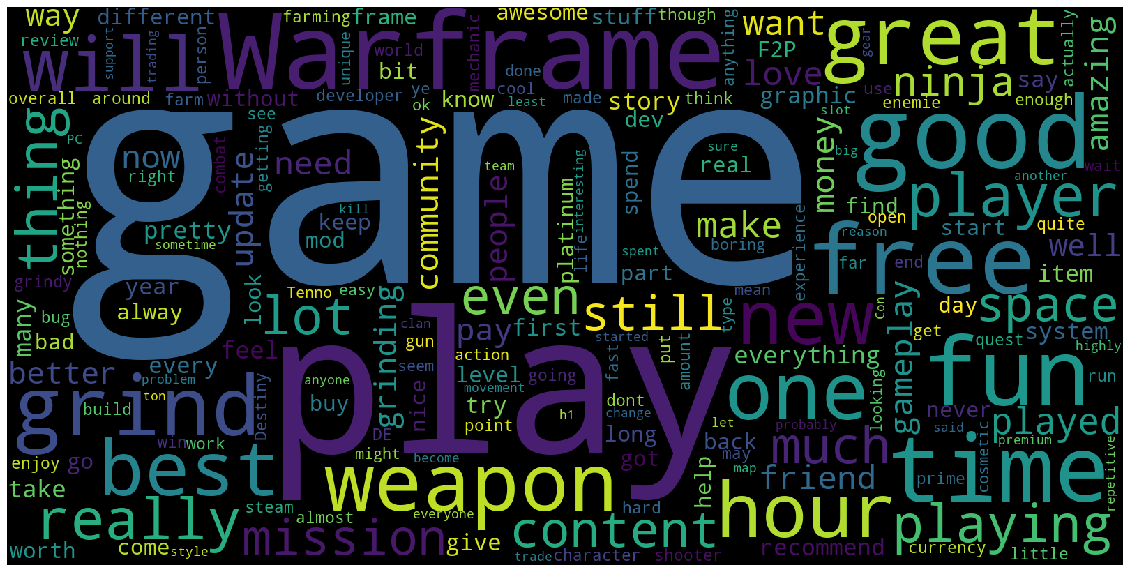

In [11]:
corpus_string = ' '.join(review_data['user_review'])
graph_word_cloud(corpus_string)

Moving on, I extract ratings (out of 10) from player reviews and discard ratings greater than 12. This retains 96% of the ratings while dealing with sparser and more extreme ratings.

In [12]:
ratings = review_data['user_review'].apply(get_review_rating)
ratings = ratings.dropna()
trimmed_ratings = ratings[ratings < 13]

In [13]:
number_ratings_initial = ratings.shape[0]
number_ratings_final = trimmed_ratings.shape[0]
percentage_ratings_trimmed = (
    get_percentage_change(number_ratings_initial, number_ratings_final)
)

print("Ratings before trimming:", number_ratings_initial)
print("Ratings after trimming:", number_ratings_final)
print("Percentage of ratings trimmed:", percentage_ratings_trimmed)

Ratings before trimming: 10357
Ratings after trimming: 9953
Percentage of ratings trimmed: 3.9


Displaying the review containing the most extreme outlier below:

In [14]:
outlier_index = ratings[np.isinf(ratings)].index[0]
review_data.loc[outlier_index, 'user_review']

'Best Game I have Played 2SPOOKY4ME 99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999/10'

I then use the ratings as they are to create a violinplot and round the ratings to reduce the number of bins within the countplot.

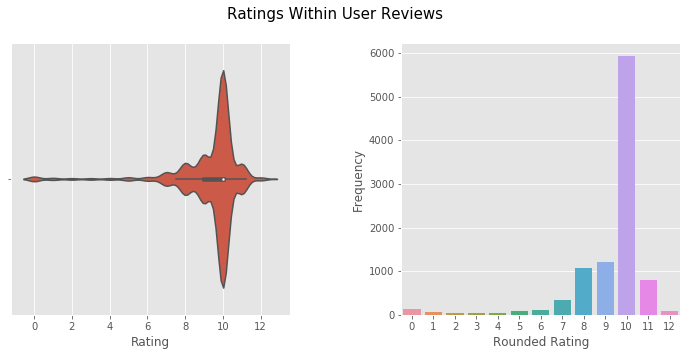

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), squeeze=False)
plt.subplots_adjust(wspace=0.4)
axes = axes.flatten()

rating_violin = sns.violinplot(x=trimmed_ratings, ax=axes[0])
rating_violin.set(xlabel="Rating")

rounded_ratings = trimmed_ratings.apply(lambda rating: round(rating, 0))
rating_bar = sns.countplot(x=rounded_ratings.astype(int), ax=axes[1])
rating_bar.set(xlabel="Rounded Rating", ylabel="Frequency")

plt.suptitle("Ratings Within User Reviews", fontsize=15)
plt.show()

The violin plot determines ratings outside of the approximate interval [7, 11] as outliers
and shows the median of the ratings to be 10. Both the violin and bar plot show that the rating 10/10 appears most frequently and that ratings tend to be higher.

In [16]:
sentiment_analyzer = SentimentIntensityAnalyzer()

review_data['sentiment_score'] = (
    review_data['user_review'].apply(sentiment_analyzer.polarity_scores)
)
review_data['sentiment_score'] = (
    review_data['sentiment_score'].apply(lambda score: score['compound'])
)

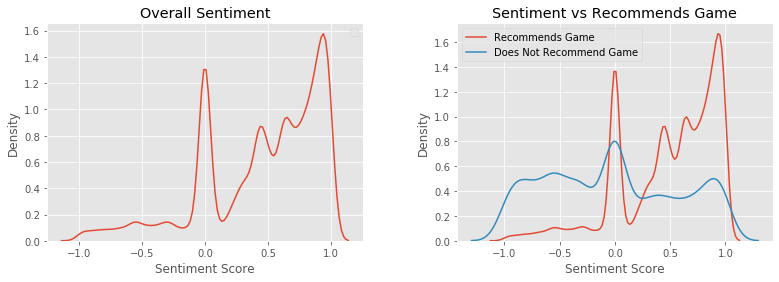

In [17]:
recommends_warframe = review_data['recommends_game'] == True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
overall_sentiment = sns.kdeplot(
    data=review_data['sentiment_score'], 
    ax=axes[0]
)
overall_sentiment.set(
    title='Overall Sentiment',
    xlabel='Sentiment Score',
    ylabel='Density'
)

recommends_sentiment = (
    review_data.loc[recommends_warframe, 'sentiment_score']
)
does_not_recommend_sentiment = (
    review_data.loc[~recommends_warframe, 'sentiment_score']
)
    
recommends_sentiment_plot = sns.kdeplot(
    data=recommends_sentiment, 
    ax=axes[1]
)
sns.kdeplot(
    data=does_not_recommend_sentiment, 
    ax=axes[1]
)
    
recommends_sentiment_plot.set(
    title='Sentiment vs Recommends Game',
    xlabel='Sentiment Score',
    ylabel='Density'
)

axes[0].legend("")
axes[1].legend(["Recommends Game", "Does Not Recommend Game"])
plt.subplots_adjust(wspace=0.3)
plt.show()

The density plots indicate that the overall sentiment scores tend to be positive - similar to the ratings contained within user reviews above. After splitting the sentiment scores based on whether or not a user recommends Warframe we can see that the reviews of users who do not recommend Warframe tend to be more negative.

Moving on, I preprocess reviews by converting to lowercase and removing stopwords/punctuation before hard coding the terms I'm interested in and applying the CountVectorizer and TfidfTransformer.

In [18]:
review_data['preprocessed_review'] = (
    review_data['user_review'].apply(preprocess_review)
)
preprocessed_corpus = [
    ' '.join(review) for review in review_data['preprocessed_review']
]

In [19]:
instance_names = ["Fortuna", "Vallis", "Cetus", "Plains", "dojo", "relay"]
instances = initialize_term_df(instance_names, "instance")

warframe_names = [
    "Ash", "Atlas", "Banshee", "Baruuk", "Chroma", "Ember", "Equinox",
    "Excalibur", "Frost", "Gara", "Garuda", "Gauss", "Grendel", "Harrow",
    "Hildryn", "Hydroid", "Inaros", "Ivara", "Khora", "Limbo", "Loki",
    "Mag", "Mesa", "Mirage", "Nekros", "Nezha", "Nidus", "Nova", "Nyx",
    "Oberon", "Octavia", "Revenant", "Rhino", "Saryn", "Titania", "Trinity",
    "Valkyr", "Vauban", "Volt", "Wisp", "Wukong", "Zephyr"
]
warframes = initialize_term_df(warframe_names, "warframe")

enemy_names = ["Corpus", "Grineer", "Infested"]
enemies = initialize_term_df(enemy_names, "enemy")

npc_names = ["Lotus", "Clem", "Baro"]
npcs = initialize_term_df(npc_names, "npc")

# mission locations on the star chart
location_names = [
    "Mercury", "Venus", "Earth", "Mars", "Phobos",  
    "Ceres", "Void", "Jupiter", "Saturn", "Europa", 
    "Uranus", "Neptune", "Pluto", "Sedna", "Derelict"
]
locations = initialize_term_df(location_names, "location")

terms = [instances, warframes, enemies, npcs, locations]
term_data = pd.concat(terms)
term_data.reset_index(drop=True, inplace=True)

In [20]:
vocab = term_data['term'].str.lower()
pipe = Pipeline(
    [('count', CountVectorizer(vocabulary=vocab)),
     ('tfidf', TfidfTransformer())]
).fit(preprocessed_corpus)
X = pipe['count'].transform(preprocessed_corpus)
count_array = pd.DataFrame(X.toarray())
term_data['frequency'] = count_array.sum()
term_data['tfidf_score'] = pipe['tfidf'].idf_

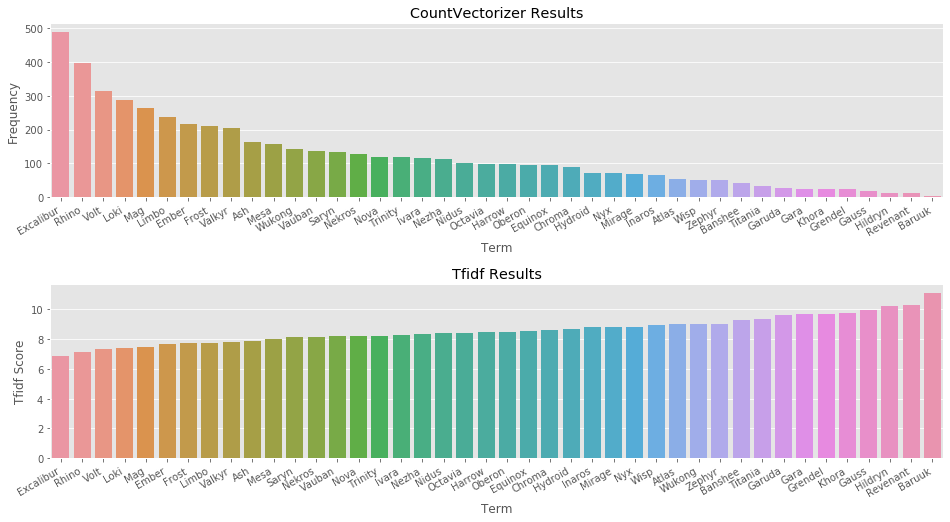

In [21]:
warframe_name_data = term_data[term_data['label'] == "warframe"]
warframe_name_sorted_frequency = (
    warframe_name_data.sort_values('frequency', ascending=False)
)
warframe_name_sorted_tfidf = (
    warframe_name_data.sort_values('tfidf_score', ascending=True)
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
axes = axes.flatten()
for axis in axes:
    plt.setp(axis.get_xticklabels(), rotation=30, ha="right")
    
warframe_frequency_bar = sns.barplot(
    x="term",
    y="frequency",
    data=warframe_name_sorted_frequency, ax=axes[0]
)
warframe_frequency_bar.set(
    title="CountVectorizer Results",
    xlabel="Term",
    ylabel="Frequency"
)

warframe_tfidf_bar = sns.barplot(
    x="term", 
    y="tfidf_score", 
    data=warframe_name_sorted_tfidf, 
    ax=axes[1]
)
warframe_tfidf_bar.set(
    title="Tfidf Results",
    xlabel="Term",
    ylabel="Tfidf Score"
)

plt.subplots_adjust(hspace=0.5)
plt.show()

After visualizing the results, we can see that the ranking for the first 5 and last 4 warframes are the same regardless of whether or not the count or tfidf score is used. On a side note, my favourite warframe [Loki](https://warframe.fandom.com/wiki/Loki) 
is ranked 4th. 

In [22]:
print("Highest ranked term for each category:")
for label in term_data['label'].unique():
    label_data = term_data[term_data['label'] == label]
    label_row = label_data['tfidf_score'].idxmin()
    print("{0}: {1}".format(label, label_data.loc[label_row, 'term']))

Highest ranked term for each category:
instance: Fortuna
warframe: Excalibur
enemy: Grineer
npc: Clem
location: Void


Links to the highest ranked terms:
<br>
[Fortuna](https://warframe.fandom.com/wiki/Fortuna), 
[Excalibur](https://warframe.fandom.com/wiki/Excalibur),
[Grineer](https://warframe.fandom.com/wiki/Grineer),
[Clem](https://warframe.fandom.com/wiki/Clem),
[Void](https://warframe.fandom.com/wiki/Void)

In [23]:
user_data['year_month_last_played'] = (
    user_data['datetime_last_played'].astype(str).apply(lambda dt: dt[0:7])
)
user_data['year_last_played'] = (
    user_data['datetime_last_played'].astype(str).apply(lambda dt: dt[0:4])
)

In [24]:
years_last_played = (
    get_date_last_played_counts(user_data, 'year_last_played')
)
years_last_played.index = years_last_played.index.astype(int)

year_months_last_played = (
    get_date_last_played_counts(user_data, 'year_month_last_played')
)

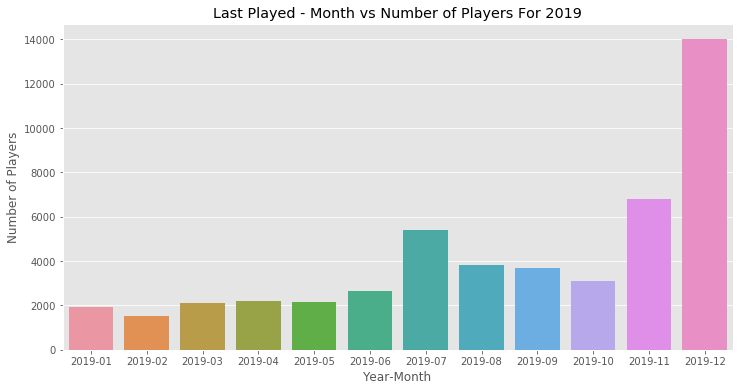

In [25]:
year = 2019 # change to view data for years between 2013 and 2020
lower_bound = "{0}-01".format(year)
upper_bound = "{0}-12".format(year)

year_months_last_played_subset = year_months_last_played[
    (year_months_last_played.index >= lower_bound) &
    (year_months_last_played.index <= upper_bound)
]

plt.figure(figsize=(12, 6))
year_month_last_played_scatter = sns.barplot(
    x=year_months_last_played_subset.index,
    y=year_months_last_played_subset
)
year_month_last_played_scatter.set(
    title="Last Played - Month vs Number of Players For {0}".format(year),
    xlabel="Year-Month",
    ylabel="Number of Players"
)
plt.show()

In [26]:
years_last_played_subset = years_last_played[:-1]
x_pred = np.arange(2013, 2020, 0.01)

linear_polynomial = get_polynomial(years_last_played_subset, 1)
linear_y_pred = linear_polynomial(x_pred)

quadratic_polynomial = get_polynomial(years_last_played_subset, 2)
quadratic_y_pred = quadratic_polynomial(x_pred)

cubic_polynomial = get_polynomial(years_last_played_subset, 3)
cubic_y_pred = cubic_polynomial(x_pred)

quartic_polynomial = get_polynomial(years_last_played_subset, 4)
quartic_y_pred = quartic_polynomial(x_pred)

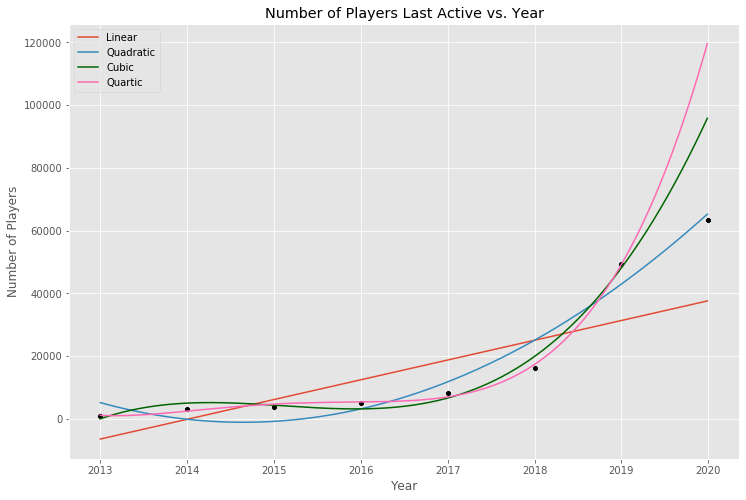


    Predicted Number of Players Last Active in 2020:
    Linear: 37595
    Quadratic: 65462
    Cubic: 96420
    Quartic: 120596
    


In [27]:
plt.figure(figsize=(12, 8))
year_last_played_scatter = sns.scatterplot(
    data=years_last_played,
    color="black"
)
year_last_played_scatter.set(
    title="Number of Players Last Active vs. Year",
    xlabel="Year",
    ylabel="Number of Players"
)

# plot best-fit lines
plt.plot(
    x_pred, linear_y_pred,
    x_pred, quadratic_y_pred,
    x_pred, cubic_y_pred, "darkgreen",
    x_pred, quartic_y_pred, "hotpink"
)
plt.legend(["Linear", "Quadratic", "Cubic", "Quartic"])
plt.show()

print(
    """
    Predicted Number of Players Last Active in 2020:
    Linear: {0}
    Quadratic: {1}
    Cubic: {2}
    Quartic: {3}
    """.format(
        int(round(linear_polynomial(2020), 0)), 
        int(round(quadratic_polynomial(2020), 0)), 
        int(round(cubic_polynomial(2020), 0)),
        int(round(quartic_polynomial(2020), 0))
    )
)

In the figure above, I use polynomials to model the number of players who stop playing Warframe in any given year. While the polynomials can be used starting points for predict the number of players who stop playing in future years, there are numerous problems regarding the efficiency and accuracy of this model.

<u>Efficiency</u>
<br>
Despite how new data can be easily added into the database, updating existing data requires re-fetching all of the reviews again using [Steam's API](https://partner.steamgames.com/doc/store/getreviews). The inefficiency of this model for games with large numbers of reviews is demonstrated by how fetching 150,000 reviews took 20 minutes.

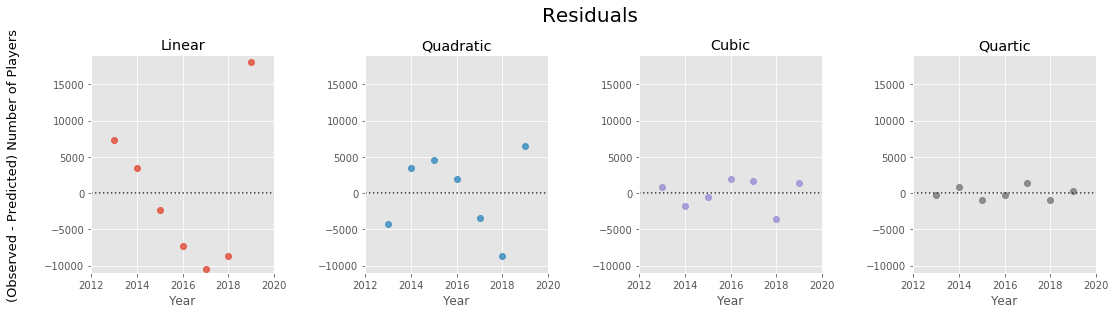

In [28]:
polynomial_types = {
    1: "Linear",
    2: "Quadratic",
    3: "Cubic",
    4: "Quartic"
}

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
fig.text(
    x=0.06, 
    y=0.5, 
    s="(Observed - Predicted) Number of Players", 
    va="center", 
    rotation="vertical", 
    fontsize=13
)

for degree in range(1, 5):
    plot_number = degree - 1
    axes[plot_number].set_xlim([2012, 2020])
    axes[plot_number].set_ylim([-11000, 19000])
    
    polynomial_type = polynomial_types[degree]
    residual_plot = sns.residplot(
        x=years_last_played[:-1].index.values,
        y=years_last_played[:-1],
        order=degree,
        ax=axes[plot_number]
    )
    residual_plot.set(title=polynomial_type, xlabel="Year", ylabel="")
    
plt.suptitle("Residuals", x= 0.51, y=1.05, fontsize=20)
plt.subplots_adjust(wspace=0.5)
plt.show()

<u>Accuracy</u>
<br>
The residuals above suggest that the quartic polynomial is the most accurate out of the four for modelling observed data. The root mean squared errors shown below demonstrate that the cubic polynomial is the best for predicting data and that the quartic polynomial may be overfitting the data. It is important to consider that the data only consists of players who play Warframe through Steam and have written a review and may not reflect the whole Warframe playerbase.

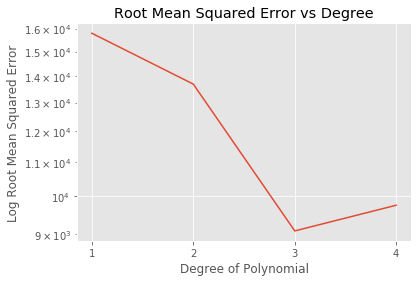

In [29]:
degrees = np.arange(1, 5)
root_mean_squared_errors = []

for degree in degrees:
    root_mean_squared_errors.append(
        get_root_mean_squared_error(years_last_played_subset, degree)
    )

rmse_plot = sns.lineplot(x=degrees, y=root_mean_squared_errors)
rmse_plot.set(
    title="Root Mean Squared Error vs Degree",
    xlabel="Degree of Polynomial",
    ylabel="Log Root Mean Squared Error"
)

plt.xticks(degrees)
plt.yscale("log")
plt.show()

In [ ]:
connection.close()
engine.dispose()